In [13]:
# LF * predicted_IC を作成
import pandas as pd
import pickle
from datetime import timedelta

# predicted_IC を取得 (_results.csv のpredicted_IC_MW 列を取得)
df_pred_IC_init = pd.DataFrame()
df_pred_init = pd.read_csv('data/edft/20250616112727_JP-TYO_0.95nominaleff_snowfall_-80.0_0.197_1.0_results.csv')
df_pred_init = df_pred_init.reset_index()
# datetime を jst に変換
df_pred_IC_init['utc_datetime'] = df_pred_init['utc_datetime']
df_pred_IC_init['predicted_IC_MW'] = df_pred_init['predicted_IC_MW']
df_pred_IC_init['utc_datetime'] = pd.to_datetime(df_pred_IC_init['utc_datetime'])
df_pred_IC_init['jst_datetime'] = df_pred_IC_init['utc_datetime'] + timedelta(hours=9)
df_pred_IC_init = df_pred_IC_init.drop(columns= ['utc_datetime'])
# predicted_IC について、2024/04/01-2025/03/31 までのデータを取得
start_date = f'2024-04-01 00:00:00'
end_date = f'2025-04-01 00:00:00'
df_pred_IC = df_pred_IC_init[(df_pred_IC_init['jst_datetime'] >= start_date) & (df_pred_IC_init['jst_datetime'] < end_date)]
df_pred_IC = df_pred_IC[['jst_datetime', 'predicted_IC_MW']]
df_pred_IC = df_pred_IC.reset_index(drop=True)

# LF を取得
# DataFrameをpklから作成
pickle_file_path = 'data/edft/modelled_params_JP-TYO_20250616112727.pkl' 
# PickleファイルからDataFrameを読み込む
with open(pickle_file_path, 'rb') as file:
    df_LF_origin = pickle.load(file)
# インデックス（utc_datetime）を列に
df_LF_origin = df_LF_origin.reset_index()
# utc_datetime を datetime に変換
df_LF_origin['utc_datetime'] = pd.to_datetime(df_LF_origin['utc_datetime']) 
# # 動作を軽くするため、必要そうな部分だけ抽出（ここは必要に応じて省く）
# df_LF = df_LF_origin[df_LF_origin['utc_datetime'] >= '2010-03-31 15:00:00']
df_LF = df_LF_origin.copy()
# datetime を jst に変換
df_LF['jst_datetime'] = df_LF['utc_datetime'] + timedelta(hours=9)
# print(df_LF)
# 各年度の気象で2024FY の予測値を作成
years = list(range(1981, 2024))
# 時系列データ格納
df_list = []
for year in years:
    # 1981~2023年度までのLFを取得して分ける
    df_LF_year = df_LF.copy()
    start_date = f'{year}-04-01 00:00:00'
    end_date = f'{year + 1}-03-31 23:59:59'
    df_LF_year = df_LF_year[(df_LF_year['jst_datetime'] >= start_date) & (df_LF_year['jst_datetime'] <= end_date)]
    df_LF_year = df_LF_year.drop(columns=['utc_datetime', 'Hour'])
    df_LF_year = df_LF_year[['jst_datetime', 'Load Factor General']]
    # 2/29 の行を削除
    df_LF_year = df_LF_year[~((df_LF_year['jst_datetime'].dt.month == 2) & (df_LF_year['jst_datetime'].dt.day == 29))]
    df_LF_year = df_LF_year.reset_index(drop=True)
    # predicted_IC_MW のデータを結合
    df_year = pd.concat([df_LF_year, df_pred_IC['predicted_IC_MW']], axis=1)
    # predicted_IC_MW の値とLFの値を用いてpredicted_generation を作成（なぜか同じ割合で少しずれるようなので補正（* 1.028983799））
    df_year['predicted_generation_MW'] = df_year['Load Factor General'] * df_year['predicted_IC_MW'] * 1.028983799
    # GWh に変換した列を作成する
    df_year['predicted_generation_GWh'] = df_year['predicted_generation_MW'] / 1000
    df_year_out = df_year.drop(['predicted_generation_MW'], axis=1)
    # 各列名に年を追加してリストに保存
    df_year_out_renamed = df_year_out.copy()
    df_year_out_renamed.columns = [f'{col}_{year}' for col in df_year_out.columns]
    df_list.append(df_year_out_renamed)

    # 月毎の合計値を計算する
    df_year['year-month'] = df_year['jst_datetime'].dt.to_period('M')
    df_month_sum = df_year.groupby('year-month')['predicted_generation_MW'].sum().reset_index()
    df_month_sum['date'] = df_month_sum['year-month'].dt.to_timestamp()
    df_month_sum = df_month_sum[['date','predicted_generation_MW']]
    df_month_sum['predicted_generation_GWh'] = df_month_sum['predicted_generation_MW'] / 1000
    df_month_sum = df_month_sum[['date','predicted_generation_GWh']]
    # 年度ごとの月次合計をGWhに変換し、12か月分をDataFrameとして保存
    df_month_sum['month'] = df_month_sum['date'].dt.month
    df_month_sum_gwh = df_month_sum[['month', 'predicted_generation_GWh']].copy()

    # すべての年度のデータを一つのDataFrameとしてまとめる
    if 'df_monthly_sum_GWh' not in globals():
        df_monthly_sum_GWh = pd.DataFrame(index=range(1, 13))

    df_monthly_sum_GWh[f'{year}'] = df_month_sum_gwh.set_index('month')['predicted_generation_GWh']

# timeseriesデータを格納    
df_combined = pd.concat(df_list, axis=1)

# 2024FY と実績も追加する。
actl_start_date = f'2024-04-01 00:00:00'
actl_end_date = f'2025-04-01 00:00:00'
# 2024FY と実績の取得
df_2024FY_met_and_actual = df_pred_init
df_2024FY_met_and_actual['utc_datetime'] = pd.to_datetime(df_2024FY_met_and_actual['utc_datetime'])
df_2024FY_met_and_actual['jst_datetime'] = df_2024FY_met_and_actual['utc_datetime'] + timedelta(hours=9)
df_2024FY_met_and_actual['predicted_generation_GWh'] = df_2024FY_met_and_actual['predicted_generation_MW'] / 1000
df_2024FY_met_and_actual['actual_generation_GWh'] = df_2024FY_met_and_actual['actual_generation_MW'] / 1000
# timeseries 用データの作成
# 列名の変更

df_2024FY_met_and_actual_for_timeseries = df_2024FY_met_and_actual[['jst_datetime', 'predicted_IC_MW', 'predicted_generation_GWh', 'actual_generation_GWh']]
df_2024FY_met_and_actual_for_timeseries = df_2024FY_met_and_actual_for_timeseries[(df_2024FY_met_and_actual_for_timeseries['jst_datetime'] >= actl_start_date) & (df_2024FY_met_and_actual_for_timeseries['jst_datetime'] < actl_end_date)]
df_2024FY_met_and_actual_for_timeseries = df_2024FY_met_and_actual_for_timeseries.reset_index(drop=True)
df_2024FY_met_and_actual_for_timeseries = df_2024FY_met_and_actual_for_timeseries.rename(columns={'jst_datetime': 'jst_datetime_2024', 'predicted_IC_MW': 'predicted_IC_MW_2024', 'predicted_generation_GWh': 'predicted_generation_GWh_2024'})

# 1981-2023の気象を用いた予測値の timeseries データ (df_combined) と 2024 の気象を用いた予測値と実績値の timeseries データ (df_2024FY_met_and_actual_for_timeseries) を結合
df_timeseries = pd.concat([df_combined, df_2024FY_met_and_actual_for_timeseries], axis=1)
# timeseries データの出力
df_timeseries.to_csv("forecast_2024FY_tokyo_for_each_weather_scenario.csv", index=False)

# 月別用データの作成
df_2024FY_met_and_actual_for_month = df_2024FY_met_and_actual[['jst_datetime', 'predicted_generation_GWh', 'actual_generation_GWh']]
df_2024FY_met_and_actual_for_month = df_2024FY_met_and_actual_for_month[(df_2024FY_met_and_actual_for_month['jst_datetime'] >= actl_start_date) & (df_2024FY_met_and_actual_for_month['jst_datetime'] < actl_end_date)]
# 月別の値に変換
df_2024FY_met_and_actual_for_month['month'] = df_2024FY_met_and_actual_for_month['jst_datetime'].dt.month
df_2024FY_met_and_actual_month_sum = df_2024FY_met_and_actual_for_month.groupby('month')[['predicted_generation_GWh', 'actual_generation_GWh']].sum().reset_index()
df_2024FY_met_and_actual_month_sum = df_2024FY_met_and_actual_month_sum.set_index('month')
# df_monthly_sum_GWh のインデックスに名前をつける
df_monthly_sum_GWh.index.name = 'month'
# df_2024FY_met_and_actual_month_sum の列名を変更
df_2024FY_met_and_actual_month_sum.rename(columns={'predicted_generation_GWh': '2024', 'actual_generation_GWh': 'actual'}, inplace=True)
# df_monthly_sum_GWh と df_2024FY_met_and_actual_month_sum を結合
df_all_month_data = df_monthly_sum_GWh.join(df_2024FY_met_and_actual_month_sum, on='month')
# 1から12のインデックスを保持したまま結合する
df_all_month_data = df_all_month_data.reset_index().set_index('month')
print('Monthly Total', df_all_month_data)

# 以下ＭＡＰＥ計算
# `df_all_month_data`から新しいDataFrameを作成
df_relative_difference = df_all_month_data.copy()

# 'Actual'列の値を各列から引き、'Actual'列で割る
for column in df_relative_difference.columns:
    if column != 'actual':  # 'actual'列自身を操作する必要はない
        df_relative_difference[column] = ((df_all_month_data[column] - df_all_month_data['actual']) / df_all_month_data['actual']).abs()

# df_relative_difference の各列の平均値を計算
average_row = df_relative_difference.mean()

# 平均値の行に名前をつける
average_row.name = 'mean'

# pd.concatを使用して、DataFrameに新しい行を追加
df_relative_difference = pd.concat([df_relative_difference, average_row.to_frame().T])
# 結果を表示
print('MAPE', df_relative_difference)

# 以下確認用コード（2024FY の predicted_generation_MW と 2024FY の LF と predicted_IC_MW をかけた値との比較→ここで同じ割合で少しずれていることが確認できた）
# 2024FY の LF * predicted_IC がちゃんとpredicted_generation_MW になるか確認
df_2024FY_check_init = df_LF[df_LF['jst_datetime'] >= actl_start_date]
df_2024FY_check_init = df_2024FY_check_init[['jst_datetime', 'Load Factor General']].reset_index(drop=True)
df_2024FY_check = pd.concat([df_2024FY_check_init, df_pred_IC['predicted_IC_MW']], axis=1)
df_2024FY_check['predicted_generation_MW'] = df_2024FY_check['Load Factor General'] * df_2024FY_check['predicted_IC_MW']*1.028983799





Monthly Total               1981         1982         1983         1984         1985  \
month                                                                    
1      1945.936487  1888.551807  2024.688368  1967.346286  2018.815649   
2      2001.171637  2142.221569  2053.121431  1876.651176  2119.345392   
3      2406.985128  2221.046587  2812.381733  1600.410969  2459.818680   
4      2581.598143  2350.748323  2138.249136  2463.489814  2319.111373   
5      2420.821171  2771.355168  2680.966174  2435.177767  2473.127426   
6      1672.752131  2178.310184  2197.395972  1670.724065  1797.529287   
7      2317.892156  1919.376105  1766.981307  2365.170437  2359.525351   
8      2150.257258  2143.591652  2126.759153  2640.211468  2629.461409   
9      1856.193495  1658.266947  1517.916891  2004.650734  1612.599556   
10     1812.494839  1933.402566  1639.802690  1573.810633  1868.871980   
11     1455.014933  1227.125829  1761.400315  1583.202665  1703.333248   
12     1921.709686  1464

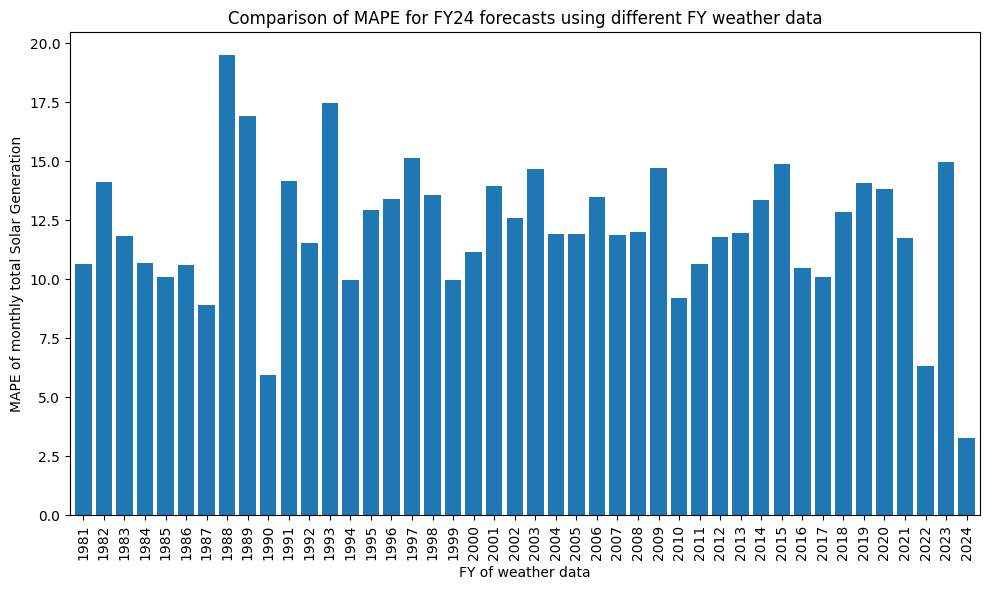

In [33]:
import matplotlib.pyplot as plt

# 'mean'行の取得（インデックスが'mean'の行を選択）
mean_values = df_relative_difference.loc['mean']

# 'actual'列を除外
mean_values = mean_values.drop('actual')
mean_values = mean_values * 100

# 棒グラフを描画
plt.figure(figsize=(10, 6))
mean_values.plot(kind='bar', width=0.8)
plt.title('Comparison of MAPE for FY24 forecasts using different FY weather data')
plt.xlabel('FY of weather data')
plt.ylabel('MAPE of monthly total Solar Generation')
plt.xticks(rotation=90)  # x軸のラベルを回転
plt.tight_layout()  # レイアウトを調整
plt.show()

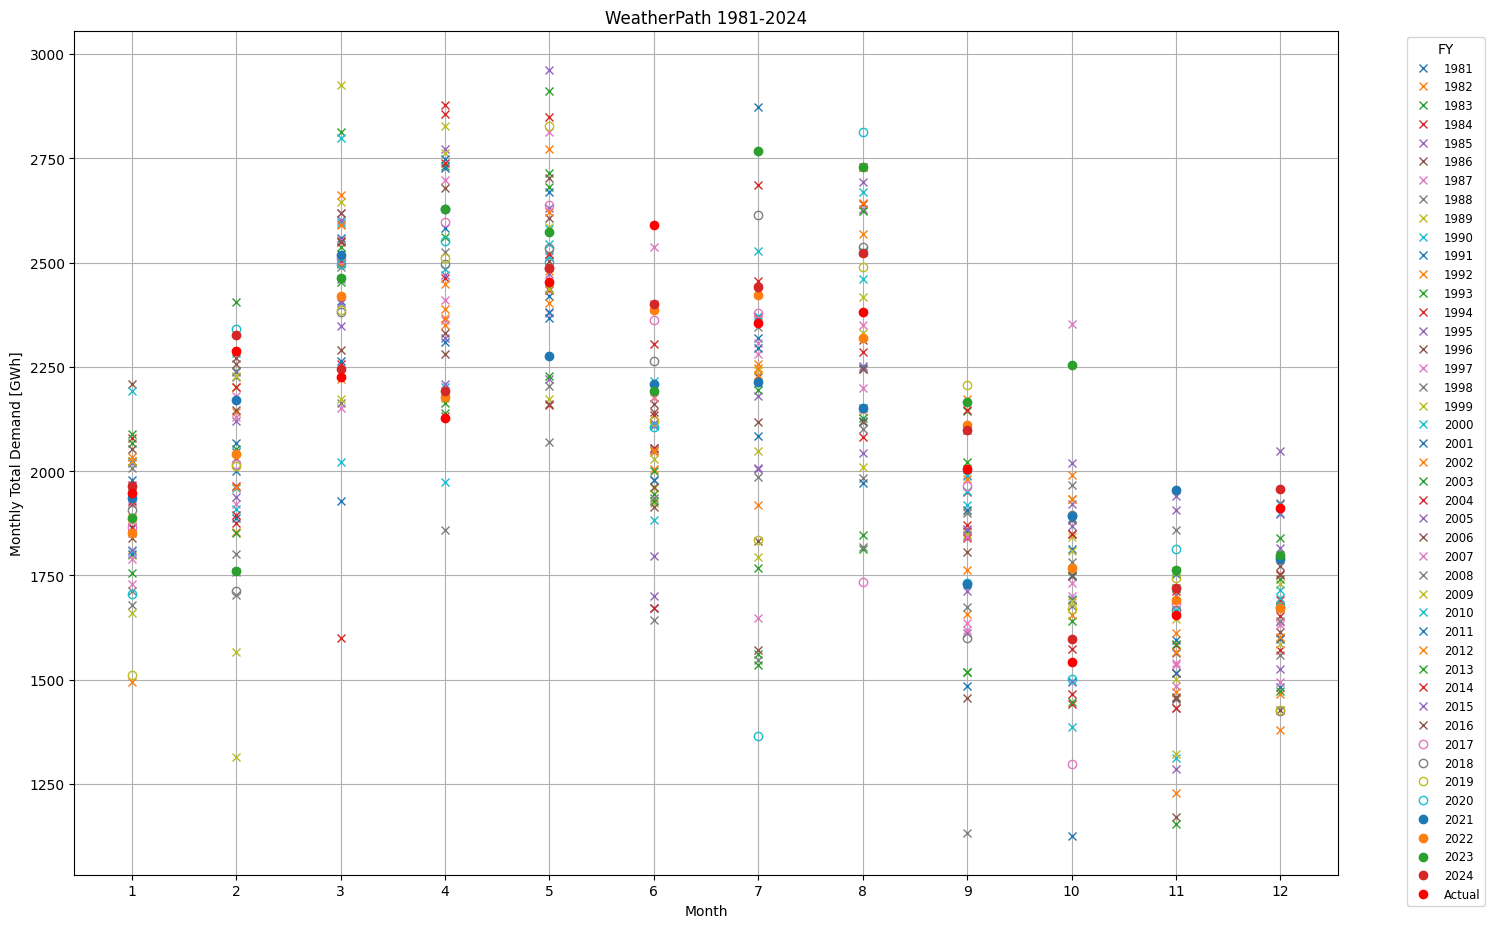

In [ ]:
import matplotlib.pyplot as plt

start_year = 1981
end_year = 2024

plt.figure(figsize=(15, 10))
for year in range(start_year, end_year + 1):
    if year <= 2016:
        plt.plot(df_all_month_data.index, df_all_month_data[str(year)], 'x', label=f"{year}")
    elif year <= 2020:
        plt.plot(df_all_month_data.index, df_all_month_data[str(year)], 'o', markerfacecolor="none", label=f"{year}")
    else:
        plt.plot(df_all_month_data.index, df_all_month_data[str(year)], 'o', label=f"{year}")

# 実績値を赤の〇で表示
plt.plot(df_all_month_data.index, df_all_month_data['actual'], 'o', color='red', label='Actual')

# setting
plt.xticks(range(1, 13)) 
plt.title(f'WeatherPath {start_year}-{end_year}')
plt.xlabel('Month')
plt.ylabel('Monthly Total Demand [GWh]')
plt.legend(title='FY', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True, axis="both") 
plt.tight_layout()
plt.show()

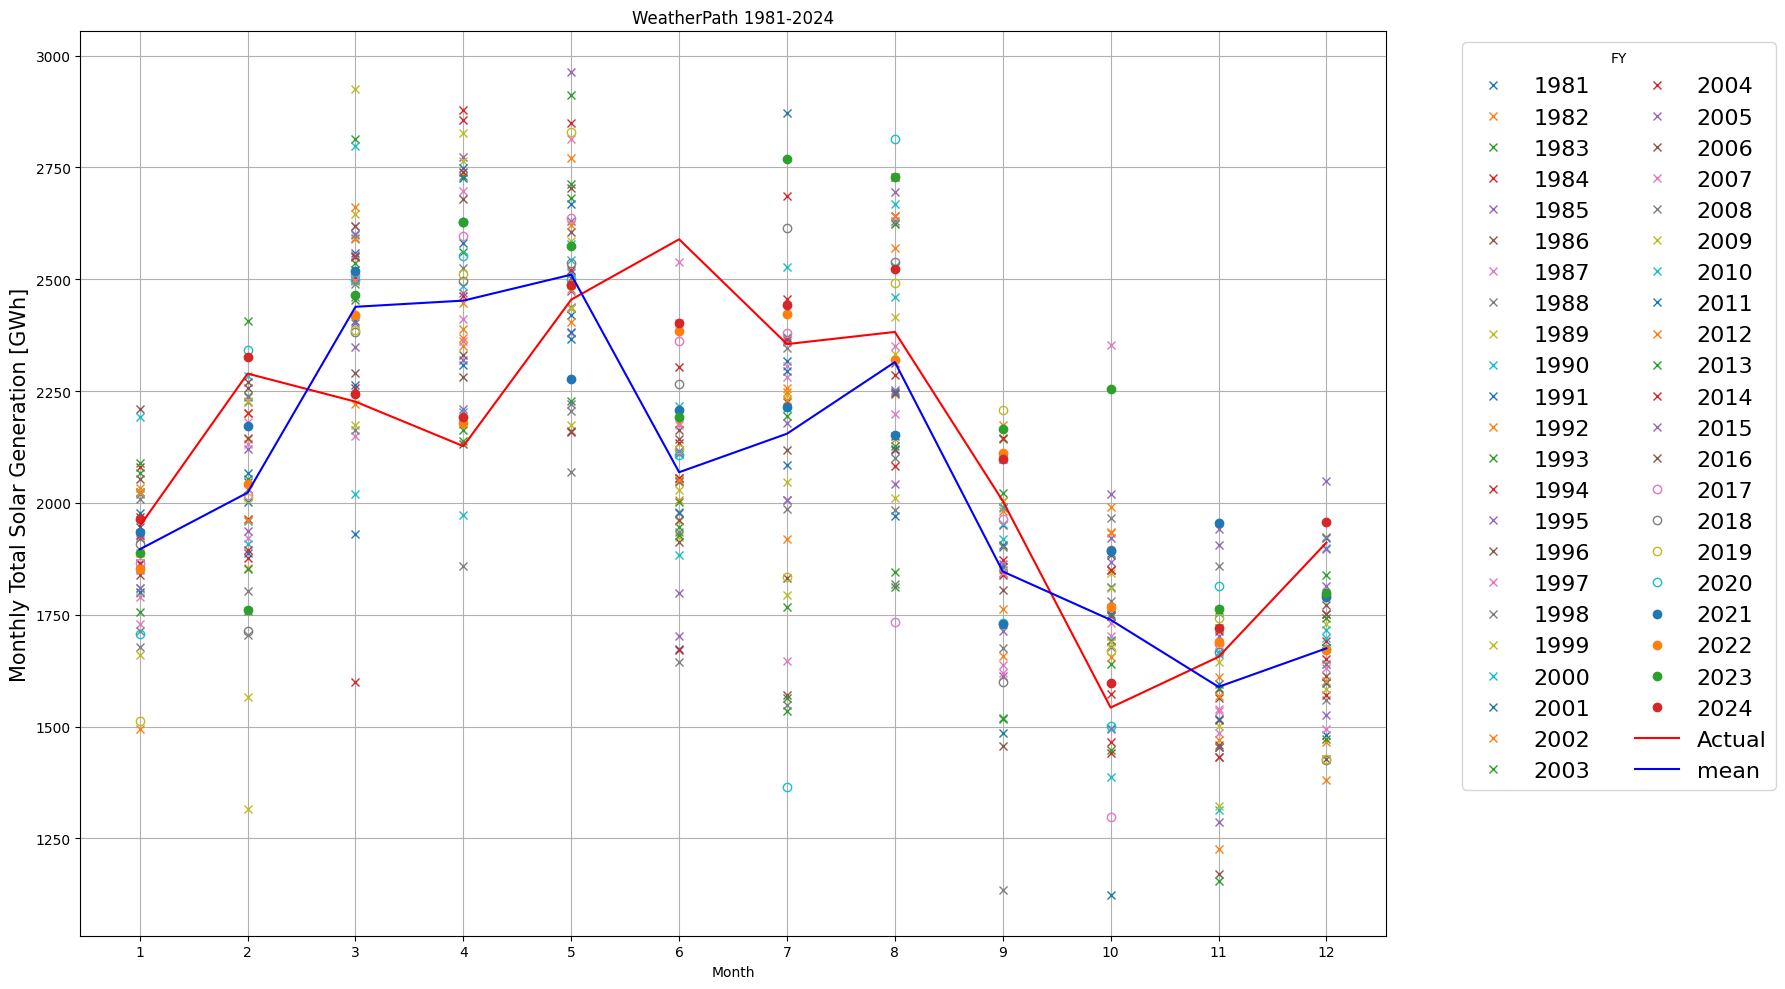

In [24]:
import matplotlib.pyplot as plt

start_year = 1981
end_year = 2024

# すべての年の平均を計算
df_all_month_data['average'] = df_all_month_data.loc[:, str(start_year):str(end_year)].mean(axis=1)

plt.figure(figsize=(18, 10))
for year in range(start_year, end_year + 1):
    if year <= 2016:
        plt.plot(df_all_month_data.index, df_all_month_data[str(year)], 'x', label=f"{year}")
    elif year <= 2020:
        plt.plot(df_all_month_data.index, df_all_month_data[str(year)], 'o', markerfacecolor="none", label=f"{year}")
    else:
        plt.plot(df_all_month_data.index, df_all_month_data[str(year)], 'o', label=f"{year}")

# 実績値を赤の線で表示
plt.plot(df_all_month_data.index, df_all_month_data['actual'], '-', color='red', label='Actual')

# 平均値を青の線で表示
plt.plot(df_all_month_data.index, df_all_month_data['average'], '-', color='blue', label='mean')

# setting
plt.xticks(range(1, 13)) 
plt.title(f'WeatherPath {start_year}-{end_year}')
plt.xlabel('Month')
plt.ylabel('Monthly Total Solar Generation [GWh]',fontsize=15)
plt.legend(title='FY', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, ncol=2)  # ここでncol=2を追加
plt.grid(True, axis="both") 
plt.tight_layout()
plt.show()